In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import re

from sklearn.model_selection  import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc

In [2]:
df1 = pd.DataFrame(pd.read_csv('train.csv'))
df2 = pd.DataFrame(pd.read_csv('test.csv'))

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

df1['Sex'] = df1['Sex'].map({'female': 1, 'male': 0})
df1['Embarked'] = df1['Embarked'].map({'Q': 1, 'C': 0, 'S': 2})
imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
df1["Age"] = imp.fit_transform(df1[["Age"]]).ravel()
df1['Embarked'] = imp.fit_transform(df1[['Embarked']]).ravel()
df1.Embarked = df1.Embarked.astype(int)
df1.Age = df1.Age.astype(int)
df1['FamilySize'] = df1['SibSp'] + df1['Parch'] + 1
df1 = df1.assign(FamilySize = pd.Series(df1['FamilySize']))
df1['HasCabin'] = df1['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
df1['Name_length'] = df1['Name'].apply(len)

#df1['IsAlone'] = 0
#df1.loc[df1['FamilySize'] == 1, 'IsAlone'] = 1

df1['Single'] = df1['FamilySize'].map(lambda s: 1 if s == 1 else 0)
df1['SmallF'] = df1['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
df1['MedF'] = df1['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
df1['LargeF'] = df1['FamilySize'].map(lambda s: 1 if s >= 5 else 0)

df1['Title'] = df1['Name'].apply(get_title)
df1['Title'] = df1['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df1['Title'] = df1['Title'].replace('Mlle', 'Miss')
df1['Title'] = df1['Title'].replace('Ms', 'Miss')
df1['Title'] = df1['Title'].replace('Mme', 'Mrs')
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
df1['Title'] = df1['Title'].map(title_mapping)
df1['Title'] = df1['Title'].fillna(0)

#df1["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df1['Cabin'] ]) #zmapowac na inty
#df1['Cabin'] = df1['Cabin'].map({'A': 1, 'B': 1, 'C': 1, 'D': 1, 'E': 1, 'F': 1, 'G': 1, 'T': 1})
df1 = df1.drop(columns = ['PassengerId', 'Cabin','Name', 'Ticket', 'Fare', 'Name_length'])
    
#============================================================================
    
df2['Sex'] = df2['Sex'].map({'female': 1, 'male': 0})
df2['Embarked'] = df2['Embarked'].map({'Q': 1, 'C': 0, 'S': 2})
imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
df2["Age"] = imp.fit_transform(df2[["Age"]]).ravel()
df2['Embarked'] = imp.fit_transform(df2[['Embarked']]).ravel()
df2.Embarked = df2.Embarked.astype(int)
df2.Age = df2.Age.astype(int)
df2['FamilySize'] = df2['SibSp'] + df2['Parch'] + 1
df2 = df2.assign(FamilySize = pd.Series(df2['FamilySize']))    
df2['HasCabin'] = df2['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
df2['Name_length'] = df2['Name'].apply(len)

#df1['IsAlone'] = 0
#df1.loc[df1['FamilySize'] == 1, 'IsAlone'] = 1

df2['Single'] = df2['FamilySize'].map(lambda s: 1 if s == 1 else 0)
df2['SmallF'] = df2['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
df2['MedF'] = df2['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
df2['LargeF'] = df2['FamilySize'].map(lambda s: 1 if s >= 5 else 0)

df2['Title'] = df2['Name'].apply(get_title)
df2['Title'] = df2['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df2['Title'] = df2['Title'].replace('Mlle', 'Miss')
df2['Title'] = df2['Title'].replace('Ms', 'Miss')
df2['Title'] = df2['Title'].replace('Mme', 'Mrs')
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
df2['Title'] = df2['Title'].map(title_mapping)
df2['Title'] = df2['Title'].fillna(0)

#df2["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df2['Cabin'] ]) #zmapowac na inty
#df2['Cabin'] = df2['Cabin'].map({'A': 1, 'B': 1, 'C': 1, 'D': 1, 'E': 1, 'F': 1, 'G': 1, 'T': 1})
df2 = df2.drop(columns = ['Name', 'Cabin', 'Ticket', 'Fare', 'Name_length'])

# print(df1)
# print(df2)

In [3]:
X = df1.drop(columns = ['Survived'])
y = df1['Survived']

skf = StratifiedKFold(n_splits = 4) #pobawic sie z iloscia splitow
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# print(X_train)
# print(X_test)

In [4]:
xgtrain = xgb.DMatrix(X_train.values, y_train.values)
xgtest = xgb.DMatrix(X_test.values)

param = {'max_depth': 3, 'eta': 1, 'silent': 1, 'objective':'binary:logistic', 'lambda': 5}
num_round = 25
bst = xgb.train(param, xgtrain, num_round)
y_predict = bst.predict(xgtest)

# for i in range(222):
#     if y_predict[i] >= 0.4:
#         y_predict[i] = 1
#     else:  
#         y_predict[i] = 0

# accuracy = accuracy_score(y_test, y_predict) 
# print(accuracy)

In [5]:
#df2 = sc.transform(df2)
#y2_pred = clf.predict(df2)
#print(df2)

Xt = df2.drop(columns = ['PassengerId'])
yt = df2['PassengerId']

yt = yt.reset_index(drop=True)
yt = pd.DataFrame(np.array(yt).reshape(len(yt)), columns = ['PassengerId'])
#print(yt)

ytt = yt

Xt = sc.transform(Xt)
Xt = pd.DataFrame(Xt)
Xt = xgb.DMatrix(Xt.values)
#print(Xt)

yt2_predict = bst.predict(Xt)

xgb_pdict = pd.DataFrame({'xgb': yt2_predict})
xgb_pdict.to_csv('pdb-xgb.csv', index = False)
#print(yt2_predict)

# for i in range(418):
#     if yt2_predict[i] >= 0.4:
#        yt2_predict[i] = 1
#     else:  
#        yt2_predict[i] = 0

#print(yt2_predict)
print(min(yt2_predict))
print(max(yt2_predict))   
    
df2t = pd.DataFrame(yt2_predict, columns = ['Survived'])
#print(df2t)

yt['Survived'] = df2t['Survived']
# yt.Survived = yt.Survived.astype(int)
# print(yt)

yt.to_csv('wynik-xgb.csv', index = False)

0.01669927
0.9933809


In [6]:
yt.Survived.value_counts()

0.073306    26
0.090624    12
0.670351    10
0.101587     7
0.224899     7
0.087421     6
0.081798     5
0.552612     5
0.343497     5
0.090778     4
0.195579     4
0.432085     4
0.089858     4
0.088487     4
0.105826     3
0.969458     3
0.135097     3
0.128889     3
0.066329     3
0.053855     3
0.200784     3
0.138734     3
0.677814     3
0.148896     3
0.963243     2
0.124738     2
0.517460     2
0.120983     2
0.907224     2
0.634864     2
            ..
0.797818     1
0.446668     1
0.023173     1
0.095554     1
0.918297     1
0.991538     1
0.462564     1
0.663400     1
0.740547     1
0.569171     1
0.728825     1
0.202958     1
0.163041     1
0.049091     1
0.854796     1
0.386382     1
0.103920     1
0.041431     1
0.052332     1
0.514946     1
0.955375     1
0.542359     1
0.345848     1
0.710729     1
0.200952     1
0.913361     1
0.582793     1
0.957304     1
0.156440     1
0.914551     1
Name: Survived, Length: 269, dtype: int64

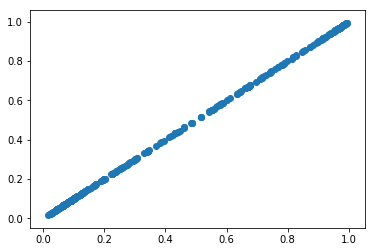

In [7]:
pt = df2['PassengerId']

#pt = pt.reset_index(drop=True)
#pt = pd.DataFrame(np.array(pt).reshape(len(pt)), columns = ['PassengerId'])

plt.scatter(yt2_predict,yt2_predict)


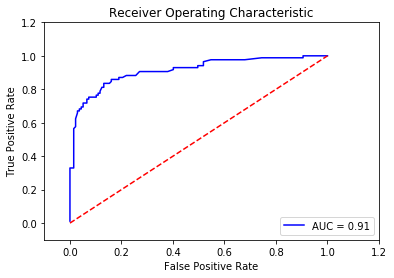

In [8]:
# Xplt = yt2_predict # false_positive_rate
# yplt = Xt # true_positive_rate 

# # This is the ROC curve
# plt.plot(Xplt,yplt)
# plt.show() 

# # This is the AUC
# auc = np.trapz(yplt,Xplt)

actual = y_test #df1['Survived']
predictions = y_predict #df2t

#print(actual)
#print(predictions)

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label = 'AUC = %0.2f'% roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()